In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
sys.path.append('../')

from game_runner import NegotitaionGame, GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prompting.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)



In [33]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [34]:
rounds = []
p1_values = []
p2_values = []
max_rounds = 3
p1_offers = []
p2_offers = []
game = NegotitaionGame(
    player1_agent=llm_agent.LLMAgent(),
    player2_agent=llm_agent.LLMAgent(),
    num_items=3,
    item_value_range=[1, 101],
    gamma=0.9,
    max_rounds=max_rounds,
    outside_offer_value_range=[1, 1000]
)

rounds = []
p1_values = []
p2_values = []

#LOOP TO RUN NEGOTIATION
while game.in_progress:  
    current_step = len(game.history[0]) + len(game.history[1]) + 1
    current_round = (current_step - 1) // 2 + 1 
    current_player = 1 if current_step % 2 == 1 else 2
    
    print(f"\n{'='*80}")
    print(f"Round {current_round}, Player {current_player}'s turn (Step {current_step})")
    print(f"{'='*80}")

    prev_offer = game.current_offer  
    game.step()  
    
    if game.current_offer: #NORMAL ROUNDS
        #p1_kept = game.items - np.array(game.current_offer.offer)
       # p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
        #p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        
        if current_player == 1:
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
            rounds.append(current_round)
            p1_values.append(p1_value) #discounted value P1 would get from the current offer
            p2_values.append(p2_value) #discounted value P2 would get from the current offer
        if current_player == 2: #PLAYER 2 OFFERS
            rounds.append(current_round)
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
            p1_values.append(p1_value) #discounted value P1 would get from the current offer
            p2_values.append(p2_value) #discounted value P2 would get from the current offer
            p1_offers.append(prev_offer.offer)  
            p2_offers.append(game.current_offer.offer)
            print(f"\nRound {current_round} Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
    
    
    if current_round == game.max_rounds and current_player == 2: #IF WE ARE ON THE LAST ROUND
        if game.current_offer and game.current_offer != prev_offer: #IF PLAYER 2 MAKES A COUNTEROFFER WE TREAT IT AS WALK
            print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        elif game.current_offer == prev_offer: #IF PLAYER 2 ACCEPTS
            print("\nPlayer 2's final action: ACCEPT")
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        else: #IF PLAYER 2 WALKS
            print("\nPlayer 2's final action: WALK")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        
        game.in_progress = False
        print(f"\nRound {current_round} Final Values:")
        print(f"Player 1: {p1_value:.2f}")
        print(f"Player 2: {p2_value:.2f}")
        
        rounds.append(current_round)
        p1_values.append(p1_value)
        p2_values.append(p2_value)
        break

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")


Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 3 types of items, called item 1 through item 3.
    There are 7 units of item 1, 6 units of item 2, 5 units of item 3 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 90 for item 1, 74 for item 2, 85 for item 3.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 113.

    The negotiation proceeds in 3 rounds.
    There is a discount rate gamma = 0.9, such that if the process concludes after r rounds the overall value of the negotiation to each player is their value for the outcome multiplied by gamma to the power r-1 where r is the ro

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



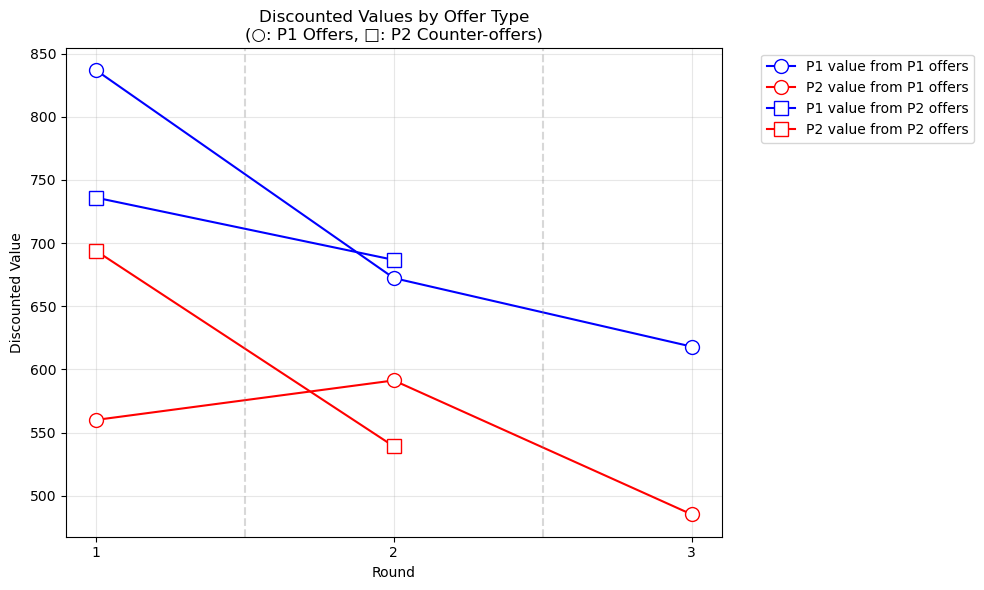


Final Values:
Player 1: 618.03
Player 2: 485.19


In [35]:
if game.current_offer: 
    plot_discounted_values(rounds, p1_values, p2_values, max_rounds)

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")

## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 5
Number of P1 offers: 2
Number of P2 offers: 2


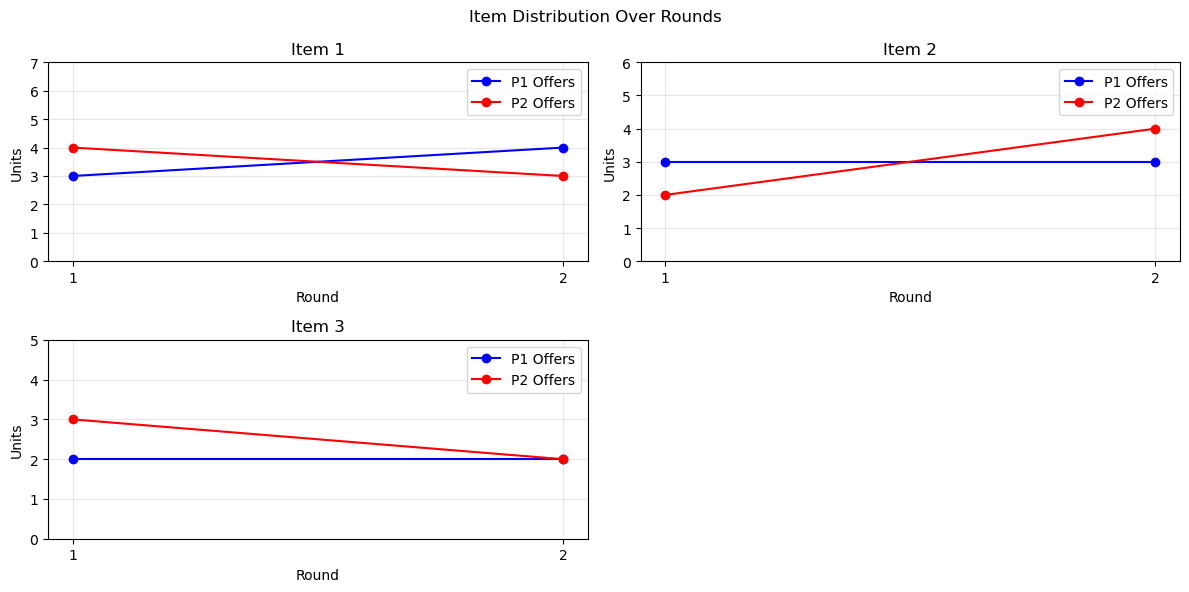

In [36]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

## Negotiation Gap Plot Description

This visualization tracks the difference in value between Player 1 and Player 2's positions over the negotiation rounds.

### Calculation
For each round, the value gap is calculated as: value_gap = (P1_value - P2_value) / (P1_value + P2_value)


### Visual Elements
- Green line: Shows the value difference between players
- Positive values: P1 getting more value than P2
- Negative values: P2 getting more value than P1

### Interpretation
- Values closer to zero indicate more balanced offers
- Convergence toward zero suggests players moving toward agreement
- Persistent gaps may indicate difficulty reaching consensus
- Shows how unequal the split is relative to what's actually being offered and each's valuation

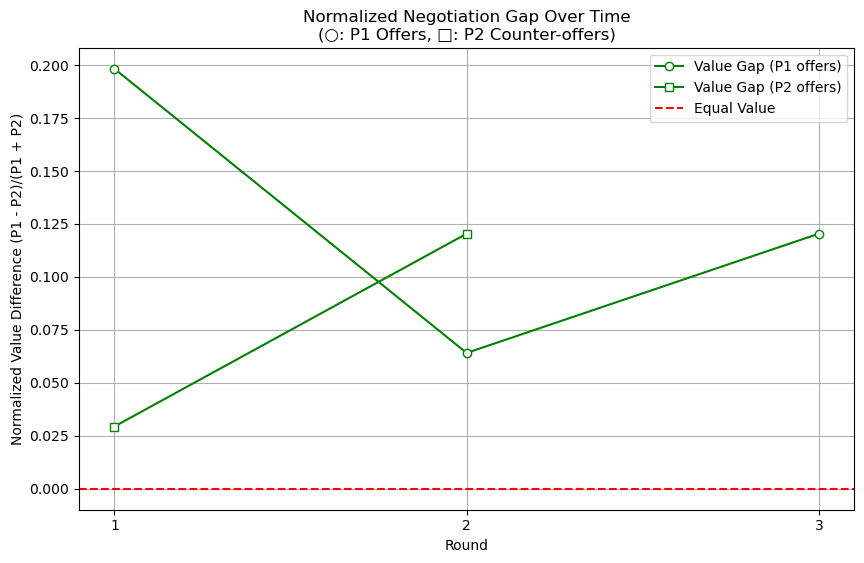

In [37]:

if game.current_offer:
    plot_negotiation_gap(rounds, p1_values, p2_values) 

## Basic Fairness Plot

This visualization shows how the total value is distributed between players over rounds.

### Calculation
For each round, the fairness ratio is calculated as:
- P1's share = P1_value / (P1_value + P2_value)
- P2's share = P2_value / (P1_value + P2_value)

### Visual Elements
- Blue line (○): Player 1's proportion of total value
- Red line (○): Player 2's proportion of total value 
- Green dashed line: Equal split reference (0.5)

### Interpretation
- Values closer to 0.5 indicate a more equal distribution
- Values above 0.5 on blue line show P1 getting more value
- Values above 0.5 on red line show P2 getting more value



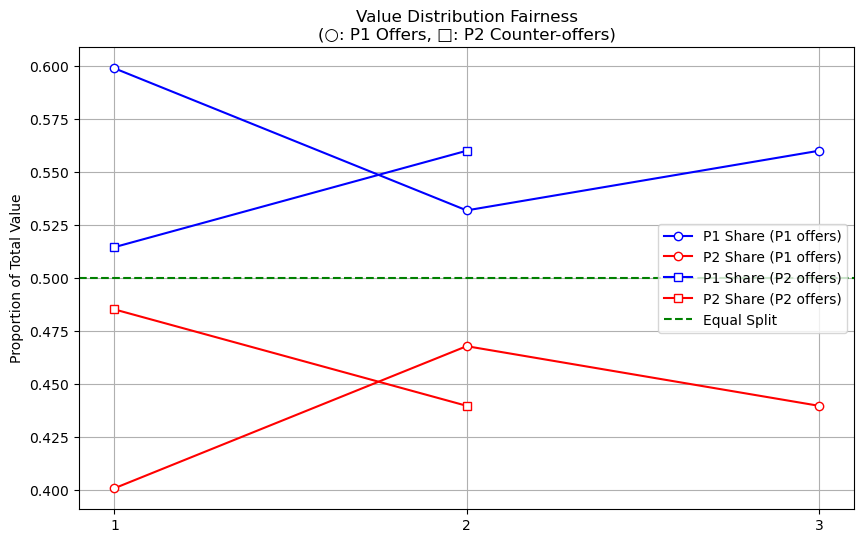

In [38]:
if game.current_offer:
    plot_fairness(rounds, p1_values, p2_values)


In [39]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")


Basic Metrics:
Final P1 Value: 618.03
Final P2 Value: 485.19
Final Value Gap: 132.84
Final Fairness Ratio: 0.56 : 0.44

Final Division of Items:
Total Items Available: [7 6 5]
P1 Received: [4, 2, 3]
P2 Received: [3, 4, 2]

Negotiation Evaluation:
Outside Offer Rational: Yes
P1 Valuation of Each Item: [90 74 85]
P2 Valuation of Each Item: [97 39 76]
